In [50]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from IPython.display import Markdown, display

## Code

In [51]:
def create_donut_charts(dataframes, column_names, titles=None):
    if titles is None:
        titles = column_names
        
    num_bar_charts = len(dataframes)
    fig, axs = plt.subplots(1, num_bar_charts, figsize=(7.5 * num_bar_charts, 6))

    for i, df in enumerate(dataframes):
        values = df[column_names[i]]
        labels = [*df.index]
        print(values)
        total = sum(values)
        axs[i].pie(
            values,
            labels=labels,
            # colors=colors,
            autopct=lambda p: f"{p:.0f}% ({p * total / 100:.0f})" if p > 0 else "0",
            startangle=140,
            wedgeprops=dict(width=0.25, edgecolor="w", linewidth=0.25),
            textprops=dict(color="black", fontsize=10),
        )
        axs[i].set_title(titles[i])
        axs[i].axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.tight_layout()
    # plt.show()
    return fig

In [52]:
from numba import jit, float64, int64, boolean

def get_token_array(wallet_df, wallet_types):
    return np.array(
        wallet_df[wallet_df.type.isin(wallet_types)]['total_token_share'].sort_values(
            ascending=False))

@jit(nopython=True)
def recursive_count_numba_optimized2(token_array, min_remaining_sums, threshold, start_idx, remaining_depth, current_sum, valid_combinations):
    n = len(token_array)
    
    # Early termination with more aggressive pruning
    remaining_needed = threshold - current_sum
    if remaining_depth * token_array[start_idx] < remaining_needed:
        return 0, -1
        
    if remaining_depth == 1:
        # Vectorized base case
        count = 0
        end_idx = n
        for i in range(start_idx, end_idx):
            if current_sum + token_array[i] > threshold:
                count += 1
            else:
                # Early break if we can't reach threshold anymore
                break
        return count, start_idx if count > 0 else -1
    
    if start_idx + remaining_depth > n:
        return 0, -1
    
    # More aggressive pruning using cumulative sums
    if start_idx + remaining_depth < n:
        best_possible = current_sum + min_remaining_sums[start_idx] - (
            min_remaining_sums[start_idx + remaining_depth] if start_idx + remaining_depth < n else 0
        )
        if best_possible <= threshold:
            return 0, -1
    
    count0 = 0
    last_valid_pointer = -1
    
    # Optimized loop bounds
    end_idx = min(n - remaining_depth + 1, n)
    
    # Main loop with early termination
    for pointer in range(start_idx, end_idx):
        new_sum = current_sum + token_array[pointer]
        
        # More aggressive early skip
        if new_sum + min_remaining_sums[pointer + 1] * (remaining_depth - 1) <= threshold:
            continue
            
        sub_count, sub_pointer = recursive_count_numba_optimized2(
            token_array,
            min_remaining_sums,
            threshold,
            pointer + 1,
            remaining_depth - 1,
            new_sum,
            valid_combinations
        )
        
        if sub_count == 0:
            # If no valid combinations found, later ones won't work either
            break
            
        count0 += sub_count
        last_valid_pointer = pointer
        
    return count0, last_valid_pointer

def count_n_wallets_threshold_numba_optimized2(wallet_df, wallet_types, threshold, n):
    token_array = get_token_array(wallet_df, wallet_types)
    
    # Pre-compute cumulative sums with better precision
    min_remaining_sums = np.zeros(len(token_array), dtype=np.float64)
    curr_sum = 0.0
    for i in range(len(token_array) - 1, -1, -1):
        curr_sum += token_array[i]
        min_remaining_sums[i] = curr_sum
    
    valid_combinations = np.empty(len(token_array), dtype=np.bool_)
    
    # Warmup run with small array
    if len(token_array) > 0:
        dummy_array = np.array([1.0], dtype=np.float64)
        dummy_sums = np.array([1.0], dtype=np.float64)
        recursive_count_numba_optimized2(
            dummy_array,
            dummy_sums,
            threshold,
            0,
            1,
            0.0,
            np.empty(1, dtype=np.bool_)
        )
    
    return recursive_count_numba_optimized2(
        token_array,
        min_remaining_sums,
        threshold,
        0,
        n,
        0.0,
        valid_combinations
    )

## Results

In [53]:
outpath = Path('results/wallet_analysis')
outpath.mkdir(exist_ok=True)

wallet_df = pd.read_csv(Path('data/stETH token distribution  - stETH+wstETH holders.csv'))
wallet_df.loc[wallet_df.type.isna(), 'type'] = 'Other'
wallet_df['total_token_share'] = wallet_df['total'] / wallet_df['total'].sum() * 100

In [54]:
token_array = get_token_array(wallet_df, ['Private'])
token_array2 = get_token_array(wallet_df, ['Private', 'No label', 'Other'])
print(len(token_array), len(token_array2))

762 1804


In [55]:
wallet_types = ['Private', 'Other', 'No label']

singles, pairs, triplets, quads = [], [], [], []
thresholds = np.array([.5, .75, 1., 1.25, 1.5, 1.75, 2.])
for threshold in thresholds:
    singles.append(count_n_wallets_threshold_numba_optimized2(wallet_df, wallet_types, threshold, 1))
    pairs.append(count_n_wallets_threshold_numba_optimized2(wallet_df, wallet_types, threshold, 2))
    triplets.append(count_n_wallets_threshold_numba_optimized2(wallet_df, wallet_types, threshold, 3))
    quads.append(count_n_wallets_threshold_numba_optimized2(wallet_df, wallet_types, threshold, 4))
singles = np.array(singles)
pairs = np.array(pairs)
triplets = np.array(triplets)
quads = np.array(quads)

In [56]:
df = pd.DataFrame(np.hstack([thresholds[:,np.newaxis], np.hstack([singles, pairs, triplets, quads])]),
             columns=['threshold',
                      'single_wallets', 'single_wallets',
                      'pairs', 'pairs_distinct_first_wallets',
                      'triplets', 'triplets_distinct_first_wallets',
                      'quads', 'quads_distinct_first_wallets'
                     ])
df

,threshold,single_wallets,single_wallets,pairs,pairs_distinct_first_wallets,triplets,triplets_distinct_first_wallets,quads,quads_distinct_first_wallets
0,0.50,6.0,0.0,11327.0,16.0,10841560.0,26.0,7.006722e+09,34.0
1,0.75,2.0,0.0,3739.0,9.0,3519558.0,16.0,2.228278e+09,22.0
2,1.00,2.0,0.0,3618.0,4.0,3274939.0,12.0,1.978434e+09,15.0
3,1.25,0.0,-1.0,159.0,1.0,335072.0,7.0,3.424104e+08,12.0
4,1.50,0.0,-1.0,23.0,1.0,45135.0,3.0,4.392769e+07,8.0
5,1.75,0.0,-1.0,3.0,1.0,6233.0,1.0,6.625561e+06,5.0
6,2.00,0.0,-1.0,1.0,0.0,1913.0,1.0,1.854367e+06,2.0


In [57]:
sns.set_context('notebook')

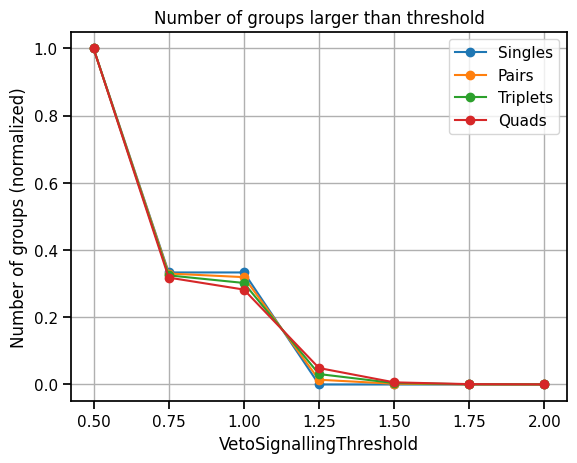

In [58]:
for arr, name in [(singles, 'singles'), (pairs, 'pairs'), (triplets, 'triplets'), (quads, 'quads')]:
    plt.plot(thresholds, arr[:,0] / np.max(arr[:,0]), label=name.capitalize(), marker='o')
plt.legend()
plt.xlabel('VetoSignallingThreshold')
plt.ylabel('Number of groups (normalized)')
plt.title('Number of groups larger than threshold')
plt.xticks(np.arange(0.5, 2.25, 0.25));
plt.grid();

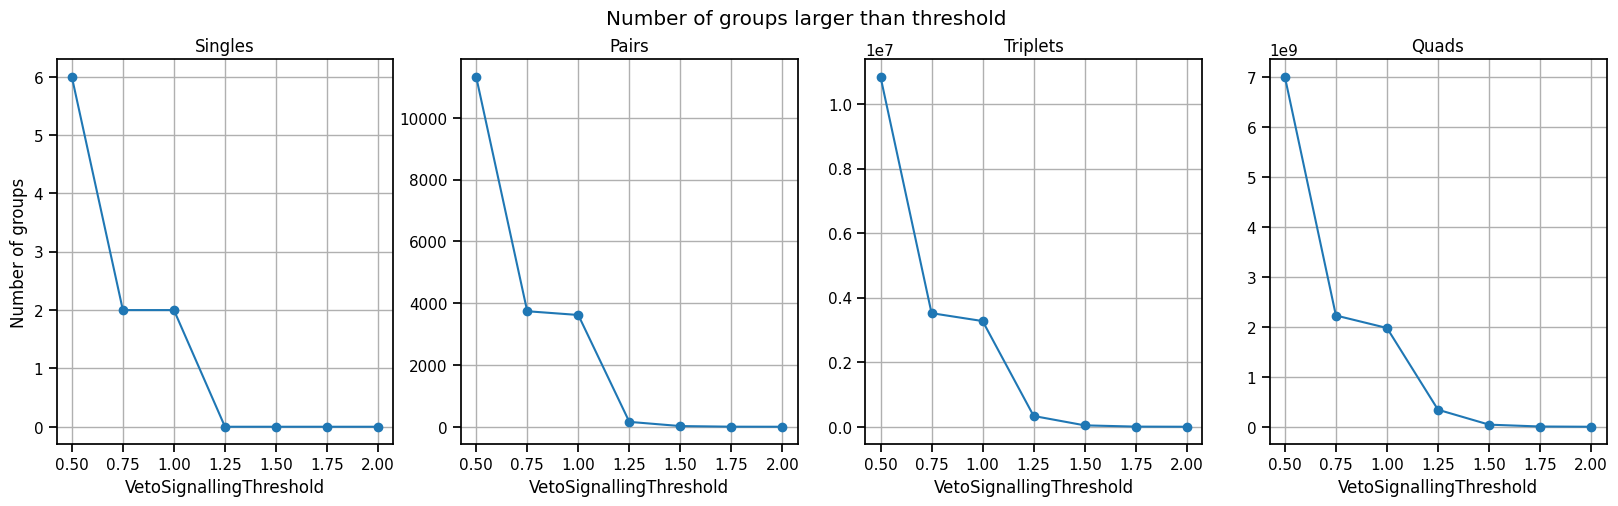

In [59]:
basesize = 5
ncols = 4
start = 0.5
step = 0.25
end = 2
fig, axes = plt.subplots(ncols=ncols, nrows=1, figsize=(basesize * ncols, basesize))
skip = np.sum(thresholds < start)
for i, (arr, name) in enumerate([(singles, 'singles'), (pairs, 'pairs'), (triplets, 'triplets'), (quads, 'quads')]):
    axes[i].plot(thresholds[skip:], arr[skip:,0], label=name, marker='o')
    axes[i].set_xlabel('VetoSignallingThreshold')
    axes[i].set_title(name.capitalize())
    axes[i].set_xticks(np.arange(start, end+step, step))
    axes[i].grid()
axes[0].set_ylabel('Number of groups')
plt.suptitle('Number of groups larger than threshold');

##### This means that to form a group of k wallets that collectively holds more tokens than a threshold one of these wallets has to participate.

##### For example there are 3274939 triplets at threshold=1.00, but each of these triplets contains one of the 12 first largest wallets. Without these first 12 wallets, large enough triplet cannot be formed.

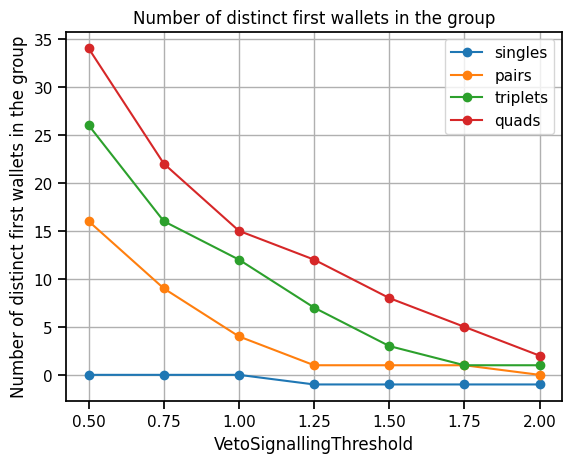

In [60]:
skip = np.sum(thresholds < start)
for arr, name in [(singles, 'singles'), (pairs, 'pairs'), (triplets, 'triplets'), (quads, 'quads')]:
    plt.plot(thresholds[skip:], arr[skip:,1], label=name, marker='o')
plt.legend()
plt.xlabel('VetoSignallingThreshold')
plt.ylabel('Number of distinct first wallets in the group')
plt.title('Number of distinct first wallets in the group')
plt.xticks(np.arange(start, end+step, step))
plt.grid()

display(Markdown(f"##### This means that to form a group of k wallets that collectively holds more tokens than a threshold one of these wallets has to participate."))
i = 2
display(Markdown(f"##### For example there are {triplets[i,0]} triplets at threshold={thresholds[i]:.2f}, but each of these triplets contains one of the {triplets[i,1]} first largest wallets. Without these first {triplets[i,1]} wallets, large enough triplet cannot be formed."))

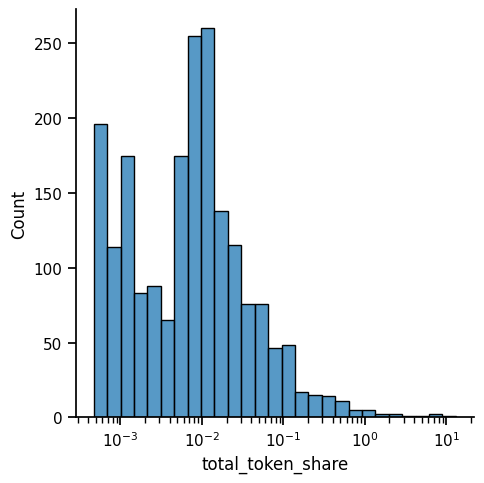

In [61]:
sns.displot(wallet_df['total_token_share'], log_scale=True)

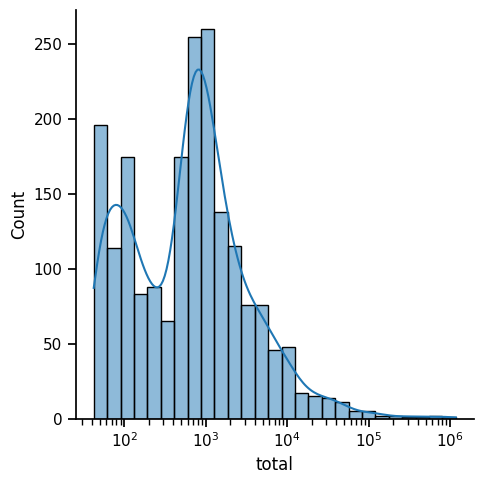

In [62]:
sns.displot(wallet_df.total, log_scale=True, kde=True)

0.8383537116783033
4518.113113
4518113113000000356352


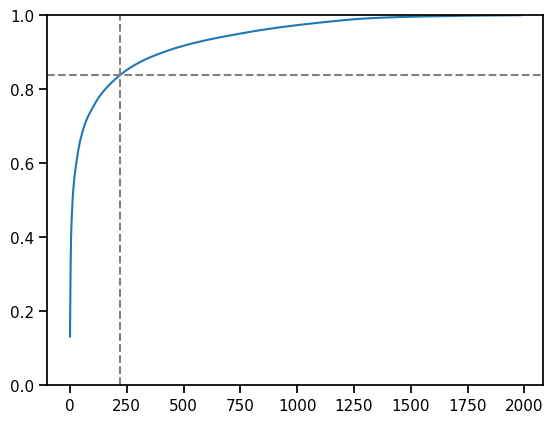

In [63]:
threshold = 0.05
balance = sorted(wallet_df.total)[::-1]
points = np.cumsum(balance) / wallet_df.total.sum()
plt.plot(points)
mask = wallet_df.total_token_share > threshold
x = np.sum(mask)
y = wallet_df[mask].total_token_share.sum() / 100
plt.plot([x, x], [0, 1], color='grey', linestyle='--')
xlim = plt.xlim()
plt.plot(xlim, [y, y], color='grey', linestyle='--')
plt.xlim(xlim)
plt.ylim(0,1)
print(y)
print(wallet_df[mask].total.min())
print(int(wallet_df[mask].total.min() * 10 **18))
# sns.displot(np.cumsum(balance), log_scale=True, kind='ecdf')

In [64]:
int(wallet_df.total.sum() * 10 ** 18)

8996416817707270275072000

In [65]:
wallet_df[mask & (wallet_df.type == 'Private')].total_token_share.sum()

np.float64(18.975416534391467)

In [66]:
wallet_df[mask & (wallet_df.type != 'Private')].total_token_share.sum()

np.float64(64.85995463343886)

In [67]:
print('mean token share:', f'{wallet_df.total_token_share.mean():.3f}%')
print('median token share:', f'{wallet_df.total_token_share.median():.3f}%')
print('mode token share:', f'{wallet_df.total_token_share.mode().iloc[0]:.3f}%')

mean token share: 0.050%
median token share: 0.007%
mode token share: 0.001%


In [68]:
threshold = 1
mask = wallet_df.total_token_share >= threshold
wallet_count = np.sum(mask)
print(f'Number of wallets holding more than {threshold:.3f}% of all tokens: {wallet_count}')
total_share = np.sum(wallet_df[mask]['total_token_share'].sum())
print(f'These wallets collectively hold {total_share:.3f}% of all tokens')

Number of wallets holding more than 1.000% of all tokens: 14
These wallets collectively hold 51.666% of all tokens


In [69]:
threshold = 0.5
mask = wallet_df.total_token_share >= threshold
wallet_count = np.sum(mask)
print(f'Number of wallets holding more than {threshold:.3f}% of all tokens: {wallet_count}')
total_share = np.sum(wallet_df[mask]['total_token_share'].sum())
print(f'These wallets collectively hold {total_share:.3f}% of all tokens')

Number of wallets holding more than 0.500% of all tokens: 25
These wallets collectively hold 58.396% of all tokens


In [70]:
threshold = 0.1
mask = wallet_df.total_token_share >= threshold
wallet_count = np.sum(mask)
print(f'Number of wallets holding more than {threshold:.3f}% of all tokens: {wallet_count}')
total_share = np.sum(wallet_df[mask]['total_token_share'].sum())
print(f'These wallets collectively hold {total_share:.3f}% of all tokens')

Number of wallets holding more than 0.100% of all tokens: 119
These wallets collectively hold 76.936% of all tokens


In [71]:
wallet_type_summary = wallet_df.groupby('type').sum(numeric_only=True)
wallet_type_summary['wallet_count'] = wallet_df.groupby('type').count()['address']
wallet_type_summary

,stETH,wstETH,total,total_token_share,wallet_count
type,,,,,
CEX,1.427789e+05,0.000000e+00,1.427789e+05,1.587065,5
Contract,2.101531e+06,3.307367e+06,5.408898e+06,60.122808,168
Custody,9.196976e+04,1.345100e+05,2.264797e+05,2.517444,9
No label,7.338029e+05,2.005121e+05,9.343150e+05,10.385413,1042
Private,1.658291e+06,6.256538e+05,2.283945e+06,25.387271,762


type
CEX            5
Contract     168
Custody        9
No label    1042
Private      762
Name: wallet_count, dtype: int64
type
CEX         1.427789e+05
Contract    5.408898e+06
Custody     2.264797e+05
No label    9.343150e+05
Private     2.283945e+06
Name: total, dtype: float64


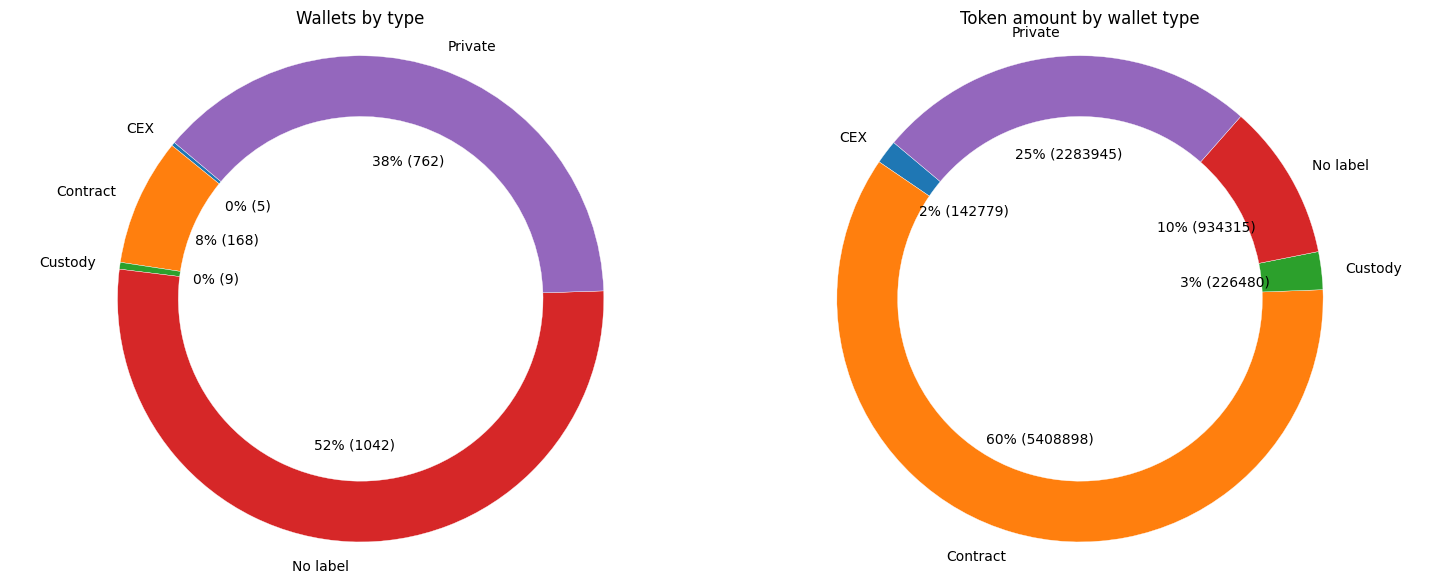

In [72]:
fig = create_donut_charts([wallet_type_summary, wallet_type_summary], ['wallet_count', 'total'], ['Wallets by type', 'Token amount by wallet type']);
fig.savefig(outpath.joinpath('wallet_type_piechart.png'))

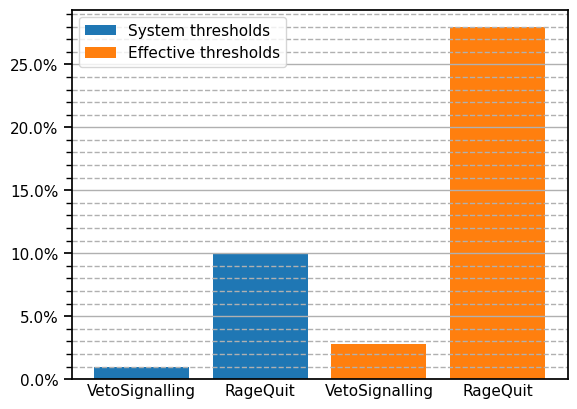

In [73]:
active_percent = (wallet_type_summary['total']['Private'] + wallet_type_summary['total']['No label']) / wallet_type_summary['total'].sum()

default_percents = np.array([1, 10])
plt.bar([0,1], default_percents, label='System thresholds')
plt.bar([2,3], default_percents / active_percent, label='Effective thresholds')
plt.xticks([0,1,2,3], labels=['VetoSignalling', 'RageQuit', 'VetoSignalling', 'RageQuit'])
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))
plt.gca().tick_params(axis=u'x', which=u'both',length=0)
plt.grid(True, axis='y')
plt.gca().grid(True, axis='y', which='minor', linestyle='--')
plt.legend()
plt.savefig(outpath.joinpath('effective_threshold_barchart.png'))